1. Import Required Libraries

In [17]:
!pip install xgboost

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA

2. Data Collection & Merging



In [19]:
# Loading the data from csv files to Pandas DataFrames
calories = pd.read_csv('calories.csv')
exercise_data = pd.read_csv('exercise.csv')

# Merge the two dataframes on a common column
calories_data = exercise_data.merge(calories, on='User_ID')

# Drop rows with null values
calories_data = calories_data.dropna()

# Debugging prints
print("Merged Data Columns:", calories_data.columns)

# Ensure the 'Calories' column is correctly included
if 'Calories' not in calories_data.columns:
    raise ValueError("The 'Calories' column does not exist in the DataFrame.")


Merged Data Columns: Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories'],
      dtype='object')


3. Advanced Feature Engineering

In [20]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Loading the data from csv files to Pandas DataFrames
calories = pd.read_csv('calories.csv')
exercise_data = pd.read_csv('exercise.csv')

# Merge the two dataframes on a common column
calories_data = exercise_data.merge(calories, on='User_ID')

# Drop rows with null values
calories_data = calories_data.dropna()

# Calculate BMI and create Age Group
calories_data['BMI'] = calories_data['Weight'] / ((calories_data['Height'] / 100) ** 2)
calories_data['Age_Group'] = pd.cut(calories_data['Age'], bins=[0, 18, 30, 50, 100], labels=['Youth', 'Young Adult', 'Middle-Aged', 'Senior'])

# Create polynomial interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(calories_data[['Weight', 'Duration', 'Heart_Rate']])
poly_columns = poly.get_feature_names_out(['Weight', 'Duration', 'Heart_Rate'])

# Concatenate polynomial features to the original DataFrame
calories_data = pd.concat([calories_data, pd.DataFrame(poly_features, columns=poly_columns)], axis=1)

# Debugging prints to check the updated DataFrame
print("Updated Merged Data Columns:", calories_data.columns.tolist())


Updated Merged Data Columns: ['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories', 'BMI', 'Age_Group', 'Weight', 'Duration', 'Heart_Rate', 'Weight Duration', 'Weight Heart_Rate', 'Duration Heart_Rate']


4. Handling Rare Categories in Categorical Variables

In [21]:
# Replace rare categories in Gender
calories_data['Gender'] = calories_data['Gender'].apply(lambda x: 'Other' if x not in ['male', 'female'] else x)

5. Exploratory Data Analysis (EDA)

In [22]:
# Check for non-numeric columns
non_numeric_columns = calories_data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

calories_data_numeric = calories_data.drop(columns=non_numeric_columns)

calories_data['Gender'] = calories_data['Gender'].map({'male': 0, 'female': 1})

# Now drop any remaining non-numeric columns if necessary
calories_data_numeric = calories_data.select_dtypes(include=['number'])

# Check the modified DataFrame
print("Numeric Data Columns after conversion:", calories_data_numeric.columns)

Non-numeric columns: Index(['Gender', 'Age_Group'], dtype='object')
Numeric Data Columns after conversion: Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories', 'BMI', 'Weight', 'Duration',
       'Heart_Rate', 'Weight Duration', 'Weight Heart_Rate',
       'Duration Heart_Rate'],
      dtype='object')


Correlation Heatmap of Numeric Features

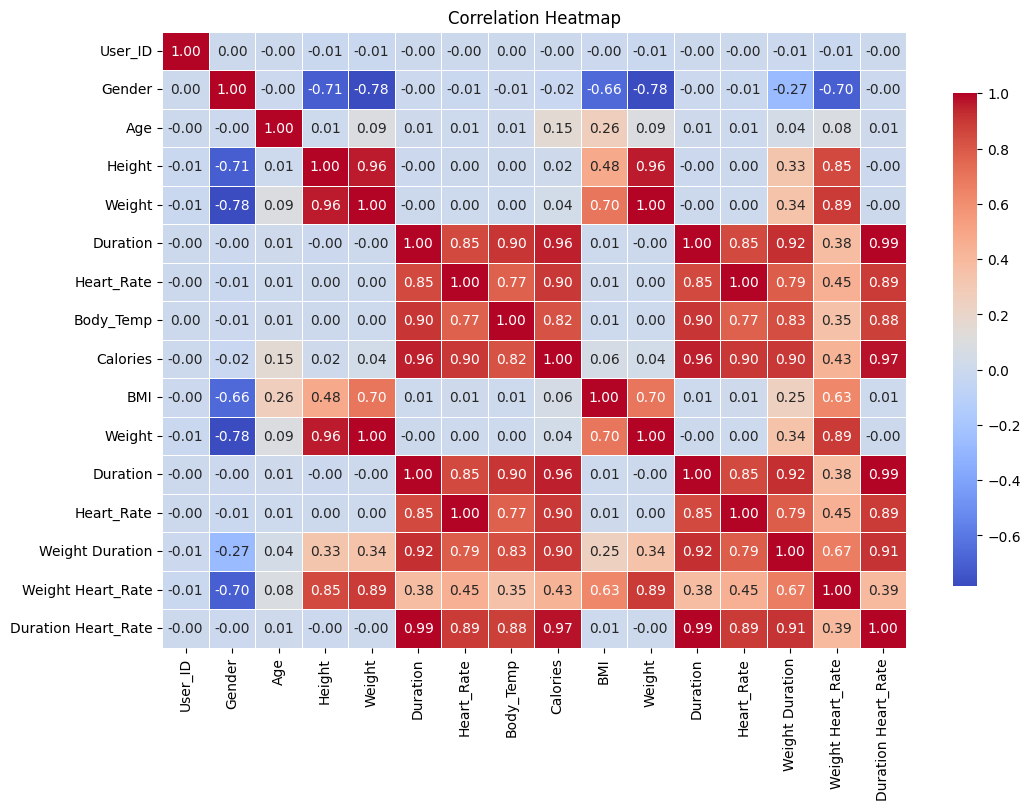

In [23]:
# Calculate and plot the correlation heatmap with increased figure size
plt.figure(figsize=(12, 8))
sns.heatmap(calories_data_numeric.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

6. Preprocessing Pipeline (Scaling, Imputation, Encoding)

In [24]:
# Remove duplicates from poly_columns if they exist
poly_columns = list(set(poly_columns))

# Define numeric features
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI'] + poly_columns

# Remove any duplicates in the final numeric_features list
numeric_features = list(set(numeric_features))

# Define categorical features
categorical_features = ['Gender', 'Age_Group']

# Check for duplicates in the final lists
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

# Remove duplicate columns from calories_data
calories_data = calories_data.loc[:, ~calories_data.columns.duplicated()]

# Verify that duplicates are removed
duplicate_columns_after = calories_data.columns[calories_data.columns.duplicated()].tolist()
print("Duplicate Columns after removal:", duplicate_columns_after)

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Print the preprocessor structure for verification
print("Preprocessing Steps:\n", preprocessor)

Numeric Features: ['Heart_Rate', 'Height', 'Weight', 'Duration', 'Duration Heart_Rate', 'Age', 'BMI', 'Weight Heart_Rate', 'Weight Duration', 'Body_Temp']
Categorical Features: ['Gender', 'Age_Group']
Duplicate Columns after removal: []
Preprocessing Steps:
 ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Heart_Rate', 'Height', 'Weight', 'Duration',
                                  'Duration Heart_Rate', 'Age', 'BMI',
                                  'Weight Heart_Rate', 'Weight Duration',
                                  'Body_Temp']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                

7. Splitting the Data

In [25]:
# Split data into features and target
X = calories_data.drop(columns=['Calories', 'User_ID'])
y = calories_data['Calories']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure the selected features from the original DataFrame are unique
X_train = X_train[numeric_features + categorical_features]
X_test = X_test[numeric_features + categorical_features]

# Apply preprocessing pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

8. Regularization: ElasticNetCV (L1 + L2 regularization)

In [26]:
# Fit ElasticNetCV model using the transformed data
elastic_net = ElasticNetCV(cv=5)
elastic_net.fit(X_train_transformed, y_train)

ElasticNetCV(cv=5)

9. Feature Selection Using Recursive Feature Elimination (RFE)


In [27]:
# Fit RFE for feature selection
xgb_model = XGBRegressor(random_state=42)
rfe = RFE(xgb_model, n_features_to_select=10)

# Fit RFE using the transformed training data
rfe.fit(X_train_transformed, y_train)

# Transform dataset to keep selected features
X_train_rfe = rfe.transform(X_train_transformed)
X_test_rfe = rfe.transform(X_test_transformed)

10. Model Building and Hyperparameter Tuning

In [28]:
# Define hyperparameter search space for XGBoost
xgb_params = {
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2)
}

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=100, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
random_search.fit(X_train_rfe, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f8b92f19720>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8b92f3e3b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f8ba15a9990>},
                   random_state=42, scoring='neg_mean_absolute_error')

11. Model Stacking and Ensemble

In [29]:
# Create stacking regressor with XGBoost and Random Forest
stacking_reg = StackingRegressor(
    estimators=[('xgb', random_search.best_estimator_), ('rf', RandomForestRegressor(n_estimators=200))],
    final_estimator=GradientBoostingRegressor(n_estimators=100)
)

# Fit stacking model
stacking_reg.fit(X_train_rfe, y_train)


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=419, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('rf', RandomForestRegressor(n_estimators=200))],
                  final_estimator=GradientBoostingRegressor())

12. Model Evaluation

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Evaluate model performance
y_pred = stacking_reg.predict(X_test_rfe)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
evs = explained_variance_score(y_test, y_pred)

# Adjusted R² calculation
n = len(y_test)  # number of observations
p = X_test_rfe.shape[1]  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print the evaluation metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape:.2f}%')
print(f'Explained Variance Score: {evs}')
print(f'Adjusted R²: {adjusted_r2}')


MAE: 0.9916802357499072
MSE: 1.954304746677365
RMSE: 1.3979645012221753
R² Score: 0.9995157567585804
MAPE: 1.88%
Explained Variance Score: 0.999515758817372
Adjusted R²: 0.9995141366741327


13. Predictions

In [31]:
# Print the predicted calories
print("Predicted Calories Burned:", y_pred)
predicted_df = pd.DataFrame(y_pred, columns=['Predicted Calories Burned'])
print(predicted_df)

Predicted Calories Burned: [173.36997018 191.99133167  52.68337279 ... 120.05989419  20.35674469
 216.04906742]
      Predicted Calories Burned
0                    173.369970
1                    191.991332
2                     52.683373
3                    162.475195
4                    224.220969
...                         ...
2995                 186.410283
2996                  53.462880
2997                 120.059894
2998                  20.356745
2999                 216.049067

[3000 rows x 1 columns]


14. Scatter Plot of Actual vs. Predicted Calories Burned with Prediction Error Visualization

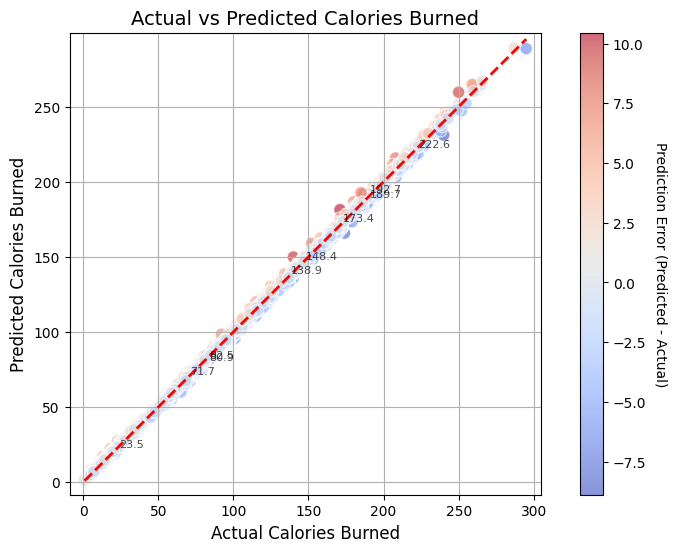

In [32]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=(y_pred - y_test), cmap='coolwarm', alpha=0.6, edgecolors='w', s=80)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Prediction Error (Predicted - Actual)', rotation=270, labelpad=15)

# Add labels and title
plt.xlabel('Actual Calories Burned', fontsize=12)
plt.ylabel('Predicted Calories Burned', fontsize=12)
plt.title('Actual vs Predicted Calories Burned', fontsize=14)

# Add a diagonal line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)

# Add grid
plt.grid()

# Annotate a few points
for i in range(0, len(y_test), max(1, len(y_test) // 10)):  # Annotate every 10th point
    plt.annotate(f"{y_pred[i]:.1f}", (y_test.iloc[i], y_pred[i]), fontsize=8, alpha=0.7)

plt.xlim([min(y_test) - 10, max(y_test) + 10])
plt.ylim([min(y_pred) - 10, max(y_pred) + 10])
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


15. Comparison of Actual and Predicted Caloric Burn Distributions Using Histogram and KDE

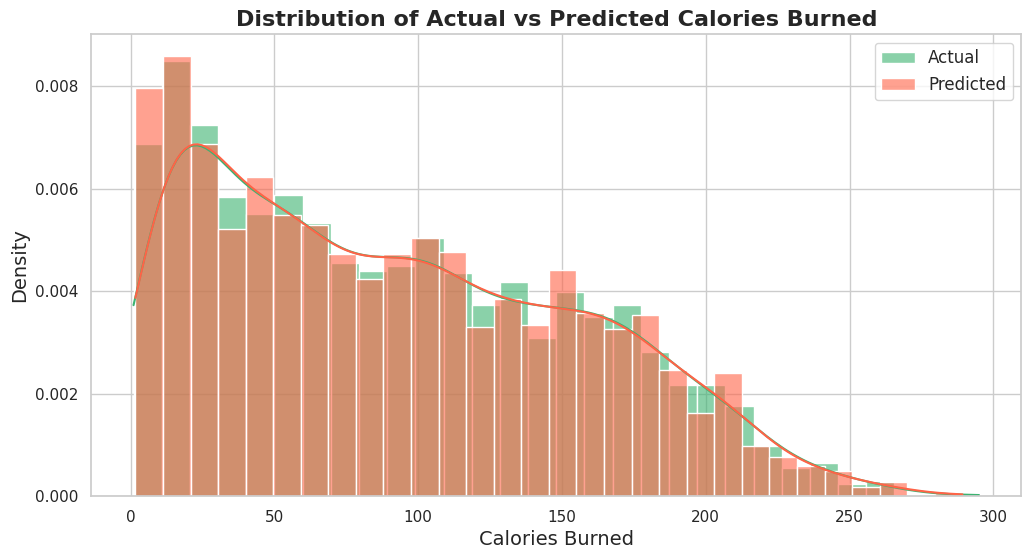

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot
sns.set(style='whitegrid')

# Create the distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(y_test, color='mediumseagreen', label='Actual', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(y_pred, color='tomato', label='Predicted', kde=True, stat='density', bins=30, alpha=0.6)

# Add titles and labels
plt.title('Distribution of Actual vs Predicted Calories Burned', fontsize=16, fontweight='bold')
plt.xlabel('Calories Burned', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add a legend
plt.legend(loc='upper right', fontsize=12)

# Add grid
plt.grid(True)

# Show the plot
plt.show()


16. Permutation Importance for Model Interpretation

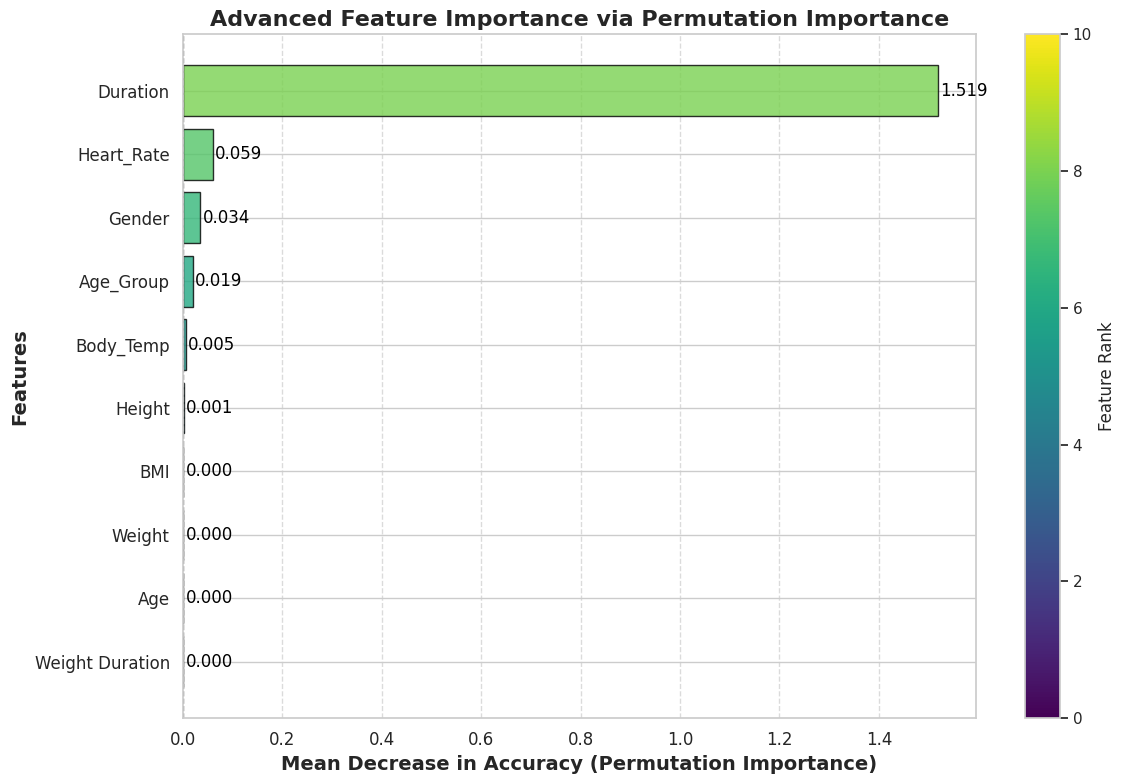

In [34]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

# Calculate permutation importance
perm_importance = permutation_importance(stacking_reg, X_test_rfe, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

# Create a more advanced plot for permutation importance
fig, ax = plt.subplots(figsize=(12, 8))  # Create a figure and axes

# Bar plot with color gradient to highlight feature importance
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_idx)))  # Color gradient for bars
ax.barh(np.array(X.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx],
        color=colors, edgecolor='black', alpha=0.8)

# Add labels and title with improved styling
ax.set_xlabel("Mean Decrease in Accuracy (Permutation Importance)", fontsize=14, fontweight='bold')
ax.set_ylabel("Features", fontsize=14, fontweight='bold')
ax.set_title("Advanced Feature Importance via Permutation Importance", fontsize=16, fontweight='bold')

# Add grid and reference line
ax.axvline(x=0, color='grey', linestyle='--', lw=1)  # Vertical reference line at zero
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Show values on bars with additional styling
for i, v in enumerate(perm_importance.importances_mean[sorted_idx]):
    ax.text(v + 0.005, i, f"{v:.3f}", color='black', va='center', fontsize=12)

# Customize ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Create a color bar for feature ranking
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=len(sorted_idx)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Feature Rank', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Show the plot


17. Residual Plot

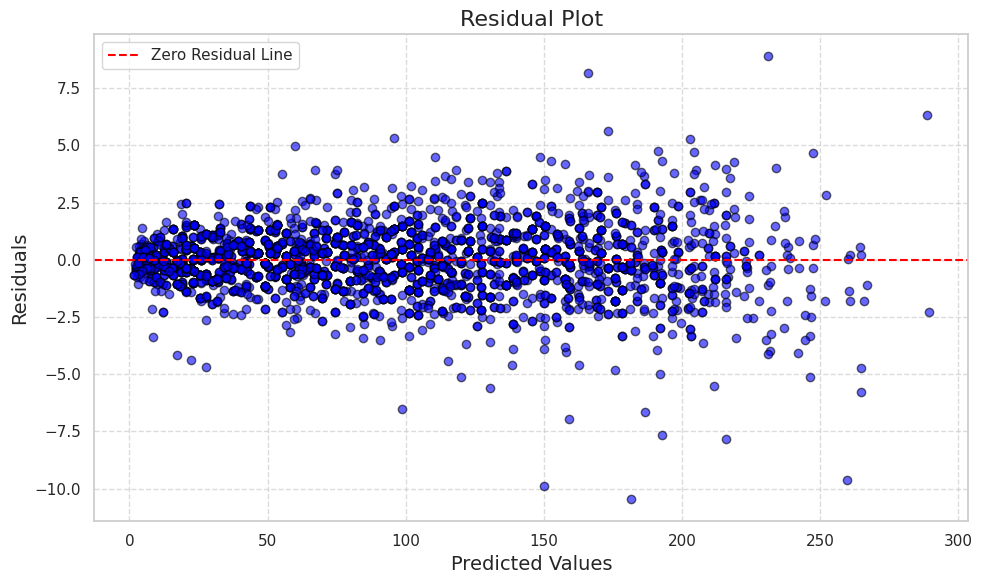

In [35]:
# Calculate residuals
residuals = y_test - y_pred

# Create residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='blue', edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual Line')
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


Step 18: Feature Selection using Lasso Regression

In [36]:
#Feature Selection using Lasso Regression
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train_rfe, y_train)

# Get selected features
selected_features = np.where(lasso.coef_ != 0)[0]
print(f"Selected Features (indices): {selected_features}")

# Create new datasets with only the selected features
X_train_selected = X_train_rfe[:, selected_features]
X_test_selected = X_test_rfe[:, selected_features]


Selected Features (indices): [1 2 3 4 5 6 7 8]


Step 19: Advanced Cross-Validation (StratifiedKFold)

In [37]:
#Advanced Cross-Validation using StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(stacking_reg, X_train_rfe, y_train, cv=skf)

# Print cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean CV score: {scores.mean():.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.99937008 0.99938497 0.99914034 0.99936296 0.99935087]
Mean CV score: 0.9993


Step 20: Final Evaluation Metrics and MAPE Visualization

Final RMSE: 1.3980
Final MAPE: 0.0188


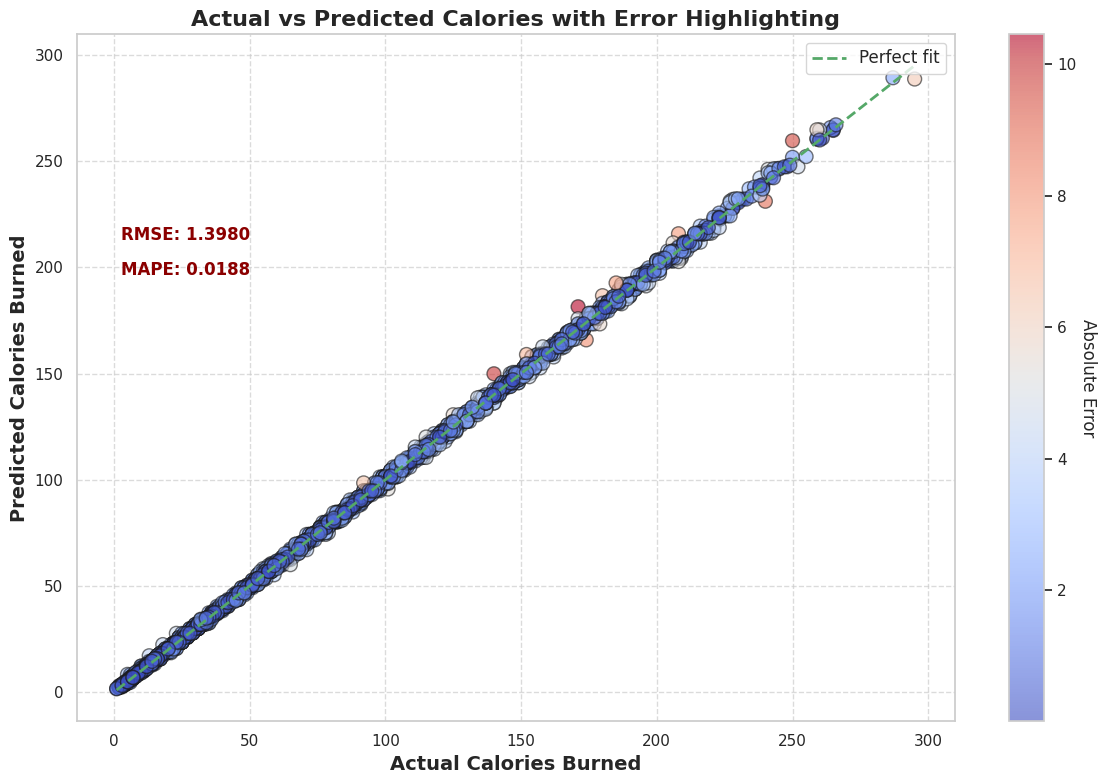

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data and calculate RMSE and MAPE
predicted_calories = stacking_reg.predict(X_test_rfe)
rmse = np.sqrt(mean_squared_error(y_test, predicted_calories))
mape = mean_absolute_percentage_error(y_test, predicted_calories)

# Print evaluation metrics
print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAPE: {mape:.4f}")

# Enhanced MAPE Visualization
plt.figure(figsize=(12, 8))

# Calculate errors
errors = np.abs(y_test - predicted_calories)

# Scatter plot with color gradient based on error
sc = plt.scatter(y_test, predicted_calories, c=errors, cmap='coolwarm', alpha=0.6, edgecolor='k', s=100)

# Plot a diagonal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2, label='Perfect fit')

# Add color bar for errors
cbar = plt.colorbar(sc)
cbar.set_label('Absolute Error', rotation=270, labelpad=15)

# Add labels and title with more styling
plt.xlabel('Actual Calories Burned', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Calories Burned', fontsize=14, fontweight='bold')
plt.title('Actual vs Predicted Calories with Error Highlighting', fontsize=16, fontweight='bold')

# Annotating RMSE and MAPE on the plot
plt.text(0.05, 0.70, f'RMSE: {rmse:.4f}', transform=plt.gca().transAxes, fontsize=12, color='darkred', weight='bold')
plt.text(0.05, 0.65, f'MAPE: {mape:.4f}', transform=plt.gca().transAxes, fontsize=12, color='darkred', weight='bold')

# Add legend for the perfect fit line
plt.legend(loc='upper right', fontsize=12)

# Improve the grid and layout aesthetics
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the enhanced plot
plt.show()


In [39]:
import joblib

# Load the best model from the PKL file
best_model_path = '/content/stacking_regressor.pkl'  # Update with the correct path
stacked_model = joblib.load(best_model_path)


In [57]:
# Evaluate model performance
y_pred = stacking_reg.predict(X_test_rfe)

# Display a summary of predictions
predictions_summary = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_summary.head(10))  # Display the first few predictions

# You can still calculate and display metrics if needed
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
evs = explained_variance_score(y_test, y_pred)

# Print a confirmation message with the metrics
print(f"Prediction done - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")



       Actual   Predicted
11499   173.0  173.369970
6475    189.0  191.991332
13167    53.0   52.683373
862     161.0  162.475195
5970    226.0  224.220969
6706    179.0  179.396142
3017     98.0  101.318464
3781     44.0   43.633987
3898     79.0   79.912961
2250     59.0   59.598095
Prediction done - MAE: 0.99, RMSE: 1.40, R²: 1.00
